In [1]:
import sys
#sys.path.append(r'D:\Anaconda\Lib\site-packages')
import pandas
import struct
#pip
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats 
import numpy as np
import pandas as pd
from scipy.fftpack import fft,ifft
from scipy.optimize import curve_fit
from scipy.optimize import root
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def mbb(MA,EQ,T2vbb,G0v,M0v,FWHM,Exposure,Abd=1):
    me=0.511
    NA=6.02e23
    k=8.5
    ln2=np.log(2)
    F=(k*EQ*FWHM**6)/me
    A=MA*k*EQ*FWHM**6
    B=ln2*NA*Exposure*Abd*0.76*me*T2vbb
    C=1/(G0v*M0v**2)
    mbb=me*(A/B)**(1/4)*C**(1/2)
    T0vbb=1/(G0v*M0v**2*(mbb/me)**2)
    SB=T2vbb/(F*T0vbb)
    Bkg=ln2*NA*k*EQ*FWHM**6*Exposure/(T2vbb*MA*me)
    return mbb,Bkg,SB,T0vbb

def sb(T2vbb,mbb,EQ,FWHM,G0v,M0v,MA):
    me=0.511
    NA=6.02e23
    k=8.5
    ln2=np.log(2)
    epsilon=0.762
    F=(k*EQ*FWHM**6)/me
    T0vbb=1/(G0v*M0v**2*(mbb/me)**2)
    sb=(T2vbb/(F*T0vbb))
    
    Es=107.6
  
    Exp=Es*MA*T0vbb/(ln2*NA*epsilon)
    print(F,sb,Es,Exp,T0vbb)
    return sb,Exp

    
def double_betaF(EQ,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    FE1=0#(E**4+10*E**3+40*E**2+60*E+30)*E*(EQ-E)**5
    FE2=E**3*(E**4+14*E**3+84*E**2+140*E+70)*(EQ-E)**7
    FE=FE1+FE2
    for i in range(pointN):
        if FE[i]<0:
            FE[i]=0
    FE=FE/np.sum(FE)
    return FE

def nless_double_betaF(EQ,FWHM,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    sigma=FWHM/2.355
    FE=np.exp(-(E-EQ)**2/(2*sigma**2))
    FE=FE/np.sum(FE)
    return FE
    
def convFWHM(FE,FWHM,range_l=0,range_h=1.2,):
    length=FE.size
    FEconv=np.zeros((length,))
    ####conv gauss fun 
    sigma=FWHM/2.355
    Width=0.5
    N=int(2*Width/(range_h-range_l)*length)
    Conv=np.linspace(-Width,Width,N)
    Gauss=np.exp(-(Conv)**2/(2*sigma**2))
    Gauss=Gauss/np.sum(Gauss)
    for i in range(length):
        for tau in range(max(i-int(N/2),0),min(i+int(N/2)-1,length)):
            FEconv[i]+=Gauss[i-tau+(int(N/2)-1)]*FE[tau] 
    return FEconv    

def convert(range_l,range_h,pointN,FWHM):
    start=int(pointN*(1-0.5*FWHM-range_l)/(range_h-range_l))
    end=int(pointN*(1+0.5*FWHM-range_l)/(range_h-range_l))
    return start, end


def nu_eff(m0):
    # unit eV
    s12=np.array([2.75,3.5])*0.1
    s23=np.array([4.27,6.09])*0.1
    s13=np.array([2.046,2.440])*0.01
    c12=1-s12
    c23=1-s23
    c13=1-s13
    m21=np.array([6.79,8.01])*1e-5
    m32=np.array([2.358,2.544])*1e-3
    #delta=np.array([141,370])*math.pi/180
    delta=0
    n1=0
    n2=0
    u1=m0*c12*c13
    u2=np.sqrt(m21+m0**2)*s12*c13*np.exp(2j*(n2-n1))
    u3=np.sqrt(m32+m21+m0**2)*s13*np.exp(-2j*(delta+n1))
    nueff=abs(u1+u2+u3)
    return nueff

In [2]:
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,2.7e-2,0.31e-2],
                     'T2vbb':[1.9,2.2,0.82],
                    'Color':['r','b','g']})       ##T2vbb is unit of 10^21 y
print(Isotope)

range_l=0
range_h=1.2
pointN=12000
E=np.linspace(range_l,range_h,pointN)
ISO_N=3

FE2v=np.zeros((pointN,ISO_N))
FE2vconv=np.zeros((pointN,ISO_N))
FE0v=np.zeros((pointN,ISO_N))
FE0vconv=np.zeros((pointN,ISO_N))
Sum2v=np.zeros((ISO_N,))
Sum0v=np.zeros((ISO_N,))
frac=np.zeros((10,))

for i in range(ISO_N):
    EQ=Isotope.loc[i,'EQ']
    FWHM=EQ*Isotope.loc[i,'FWHM']
    print(EQ,FWHM)
    FE2v[:,i]=double_betaF(EQ,pointN_=pointN)
    FE2vconv[:,i]=convFWHM(FE2v[:,i],FWHM)
    FE0vconv[:,i]=nless_double_betaF(EQ,FWHM,pointN_=pointN)

Sum2v=np.sum(FE2vconv,axis=0)
Sum0v=np.sum(FE0vconv,axis=0)
print(Sum2v,Sum0v)


start,end=convert(range_l,range_h,pointN,0.027)    
frac[0]=np.sum(FE2vconv[start:end:,1])
print(frac[0],start,end)
plt.plot(FE2vconv[start:end:,1])

#fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=500)
# ResPulse[0:65]=fit_sig_tanhg[35:100]/fit_sig_tanhg[35:100].max()

# ax[0].set(xlabel='time(us)')
# ax[1].plot(np.linspace(0,7.99,800),ResPulse[0:800])
# ax[1].set(xlabel='time(us)')
# fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/ht.png")
#np.save("E:/CDEX/ovbb/WaveSimulation/response/ResPulse.npy",ResPulse)

     ISO     EQ    FWHM  T2vbb Color
0   Ge76  2.039  0.0012   1.90     r
1  Xe136  2.458  0.0270   2.20     b
2  Te130  2.528  0.0031   0.82     g
2.039 0.0024468
2.458 0.06636600000000001
2.528 0.0078368


KeyboardInterrupt: 

In [ ]:
B_counts=0.01
S=0.01
P=0.50
Nbin=1000

ln=np.log((S+B_counts)/B_counts)
n_sample=100000
Data_Nb=stats.poisson.rvs(mu=B_counts,size=n_sample)
Data_Nsb=stats.poisson.rvs(mu=B_counts+S,size=n_sample) 
Q_Nb=-2*(Data_Nb*ln-S)
Q_Nsb=-2*(Data_Nsb*ln-S)
Min=np.min([Q_Nb.min(),Q_Nsb.min()])
Max=np.max([Q_Nb.max(),Q_Nsb.max()])
R=(Min-1,Max+1)
H_Nb,Edge=np.histogram(Q_Nb,bins=Nbin,range=R,density=True)
H_Nsb,Edge=np.histogram(Q_Nsb,bins=Nbin,range=R,density=True)
Nobs_50=np.max([0,stats.poisson.ppf(mu=B_counts,q=1-P)])  #observe s more than Nobs (poisson dist) with probability no less than 1-P
print(Nobs_50)
Qobs_50=-2*(Nobs_50*ln-S)
Nb_sum_mask=Edge[0:len(Edge)-1]<Qobs_50
Nsb_sum_mask=Edge[0:len(Edge)-1]>Qobs_50
Q_Nb_sum=H_Nb[Nb_sum_mask].sum()*(Edge[1]-Edge[0])
Q_Nsb_sum=H_Nsb[Nsb_sum_mask].sum()*(Edge[1]-Edge[0])
CLs=Q_Nsb_sum/(1-Q_Nb_sum)
print(Q_Nsb_sum,Q_Nb_sum)
print(CLs)
print(Qobs_50)
#print(Q_Nb,Q_Nsb)
plt.hist(Q_Nb,bins=Nbin,range=R,density=True)
plt.hist(Q_Nsb,bins=Nbin,range=R,density=True)

In [3]:
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                      'M(A)':[76e-6,136e-6,130e-6],             #t/mol
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,2.7e-2,0.31e-2],
                     'T2vbb':[1.9e21,2.2e21,0.82e21],
                    'Color':['r','b','g'],
                     'G0v':[2.363e-15,14.58e-15,14.22e-15],
                     'M0v':[6.13,4.32,4.98],
                     'Abd':[0.88,1,1]})       ##T2vbb is unit of 10^21 y

Exposure=3000
FWHM=[1e-2,3e-2,7.07e-2]
PointN=100
x_FWHM=np.linspace(0.12e-2,7.1e-2,PointN)
x_Exp=np.logspace(1,1e6,PointN)
Xembb_FWHM=np.zeros((PointN,))
Xembb_Exp=np.zeros((PointN,))
Mbb=np.zeros((3,))
Bkg=np.zeros((3,))
SB=np.zeros((3,))
T0vbb=np.zeros((3,))
IHmbb=14e-9
Exp=np.zeros((3,))

Isochose=2                  #1 for Xe136,2 for Te130
for i in range(0,3):
    MA   =Isotope.loc[Isochose,"M(A)"]
    EQ   =Isotope.loc[Isochose,"EQ"]
    T2vbb=Isotope.loc[Isochose,"T2vbb"]
    G0v  =Isotope.loc[Isochose,"G0v"]
    M0v  =Isotope.loc[Isochose,"M0v"]
    Abd  =Isotope.loc[Isochose,"Abd"]
    Mbb[i],Bkg[i],SB[i],T0vbb[i]=mbb(MA,EQ,T2vbb,G0v,M0v,FWHM[i],Exposure,Abd)
    SB[i],Exp[i]=sb(T2vbb,IHmbb,EQ,FWHM[i],G0v,M0v,MA)
    #print(FWHM[i])
    #Xembb_FWHM[i]=mbb(MA,EQ,T2vbb,G0v,M0v,x_FWHM[i],Exposure,Abd)
    #Xembb_Exp[i] =mbb(MA,EQ,T2vbb,G0v,M0v,FWHM[2],x_Exp[i],Abd)
#print(Mbb,Bkg,T0vbb,SB)
print(Exp)

4.2050880626223096e-11 5161.920483481064 107.6 166.19048184215308 3.7776998333881954e+27
3.065509197651662e-08 7.080823708478829 107.6 166.19048184215308 3.7776998333881954e+27
5.25159925410538e-06 0.04133280007670638 107.6 166.19048184215308 3.7776998333881954e+27
[166.19048184 166.19048184 166.19048184]


D:\Anaconda\lib\site-packages\numpy\core\function_base.py:279: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

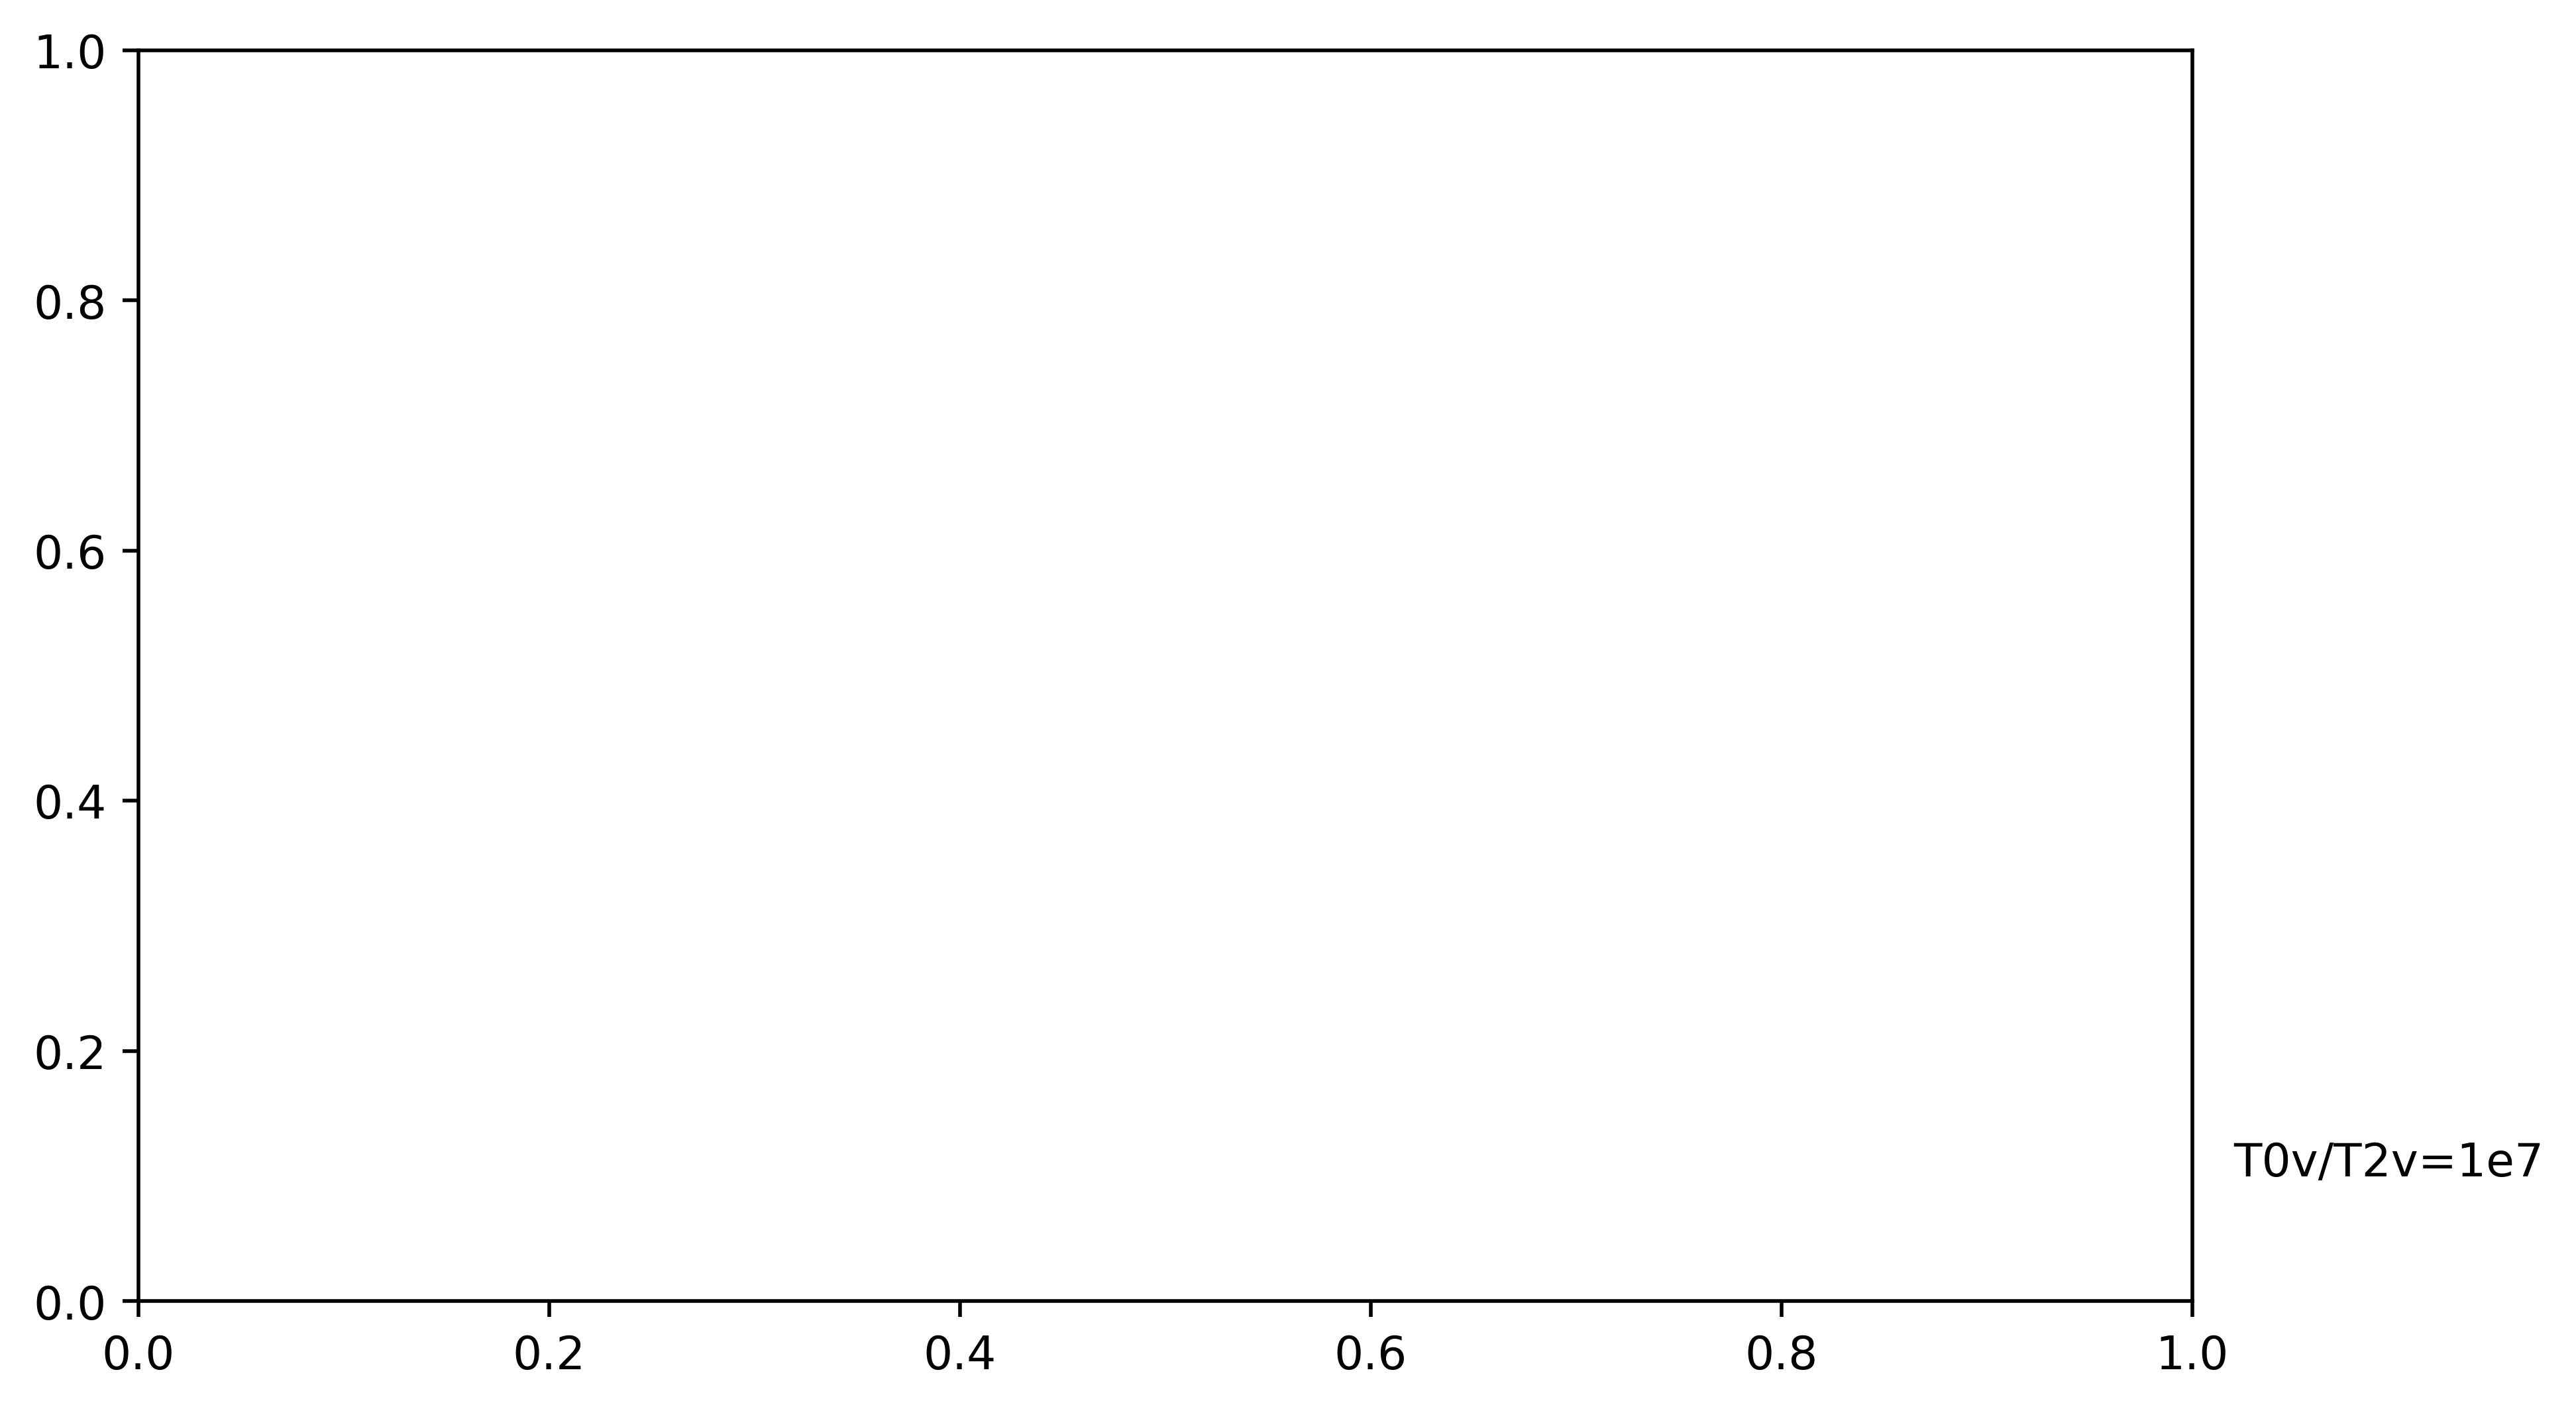

In [4]:
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=500)
t=("T0v/T2v=1e7")
plt.text(1.02,0.1,t)

ax.plot(x_FWHM,Xembb_FWHM[i],color=Isotope.loc[Isochose,'Color'])
#ax.plot(E[pltRL:pltRH],FE0vconv[pltRL:pltRH,i],color=Isotope.loc[i,'Color'],label=Isotope.loc[i,'ISO'])
ax.legend()
#ax.set_yscale("log")
ax.set(xlabel="Energy/EQ",ylabel="counts")
plt.ylim(1e-5,0.11)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/DBDSpectrum_linear_EXO.png")